In [40]:
import sys; sys.path.append('../code')

In [41]:
import pandas as pd
import cvxpy
import scipy.optimize
# import pylab as plt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import multiprocessing
import time
import copy
import pandas
import math
import os

In [42]:
import fly_plot_lib.plot as fpl # https://github.com/florisvb/FlyPlotLib
import fly_plot_lib.flymath as flymath # https://github.com/florisvb/FlyPlotLib
import figurefirst as fifi # pip install figurefirst

import pynumdiff

In [43]:
from utility import wrap_angle, correct_wind_direction_for_trisonica, mean_angle
from utility import get_lat_lon_scale, plot_wind_quivers, plot_trajec

# Load data

In [44]:
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 28}
PLT_LW = 3

matplotlib.rc('font', **font)


In [45]:
folders = {
'zig-zag':"BOTFLY_DATA_2021-07-28-16-00-54"
}
home_folder_name = '../data_experiments_preprocessed'

In [46]:
# folder = "~/Desktop/REU/BotFly/BOTFLY_DATA_2021-07-28-16-07-19"
# folder = "~/Desktop/REU/BotFly/BOTFLY_DATA_2021-07-28-15-25-47"
# folder = "~/Desktop/REU/BotFly/BOTFLY_DATA_2021-07-28-15-39-18"
# folder = "~/Desktop/REU/BotFly/BOTFLY_DATA_2021-07-28-16-00-54" # zig zag
folder = folders['zig-zag']
folder_name = folder.split("/")[-1]
print(folder, '\n', folder_name)

BOTFLY_DATA_2021-07-28-16-00-54 
 BOTFLY_DATA_2021-07-28-16-00-54


In [47]:
fname = os.path.join(home_folder_name, folder_name + '_interpolated.h5')
print(fname)

../data_experiments_preprocessed/BOTFLY_DATA_2021-07-28-16-00-54_interpolated.h5


In [48]:
interp_data  = pd.read_hdf(fname)#, key='drone_and_ground_data')

In [49]:
interp_data.keys()

Index(['D', 'S', 'Stationary_Vertical_Wind', 'ch0', 'ch1', 'ch2', 'ch3', 'ch4',
       'ch5', 'drone_wind_ang', 'drone_wind_mag', 'drone_wind_vertical',
       'gps_alt', 'gps_lat', 'gps_lon', 'imu_ang_vel_x', 'imu_ang_vel_y',
       'imu_ang_vel_z', 'imu_ang_x', 'imu_ang_y', 'imu_ang_z', 'imu_lin_acc_x',
       'imu_lin_acc_y', 'imu_lin_acc_z', 'master_time', 'opflow_ang',
       'opflow_mag'],
      dtype='object')

In [50]:
# skip this for hover
data = copy.copy(interp_data[interp_data.ch5 > 1000])


zero_diff_lon = np.where(np.diff(data.gps_lon) == 0)[0]
zero_diff_lat = np.where(np.diff(data.gps_lat) == 0)[0]
ts = []
lst = None
for idx in zero_diff_lat:
    cur = data.master_time.values[idx-1]
    if lst is not None:
        if cur - lst > 10:
            ts.append(cur)
            lst = cur
    else:
        lst = cur

In [51]:
data.master_time -= data.master_time.values[0]

# Convert lon, lat to x, y

In [52]:
dt = np.mean( np.diff(data.master_time) )

In [53]:
# scale the longitude
mean_latitude = np.mean(data.gps_lat)
longitude_origin = np.min(data.gps_lon)
longitude_max = np.max(data.gps_lon)
longitude_distance = get_lat_lon_scale([longitude_origin, mean_latitude], [longitude_max, mean_latitude])
longitude_scale = (longitude_max - longitude_origin)/longitude_distance

In [54]:
# scale the latitude
mean_longitude = np.mean(data.gps_lon)
latitude_origin = np.min(data.gps_lat)
latitude_max = np.max(data.gps_lat)
latitude_distance = get_lat_lon_scale([mean_longitude, latitude_origin], [mean_longitude, latitude_max])
latitude_scale = (latitude_max - latitude_origin)/latitude_distance

In [55]:
xpos = (data.gps_lon - np.min(data.gps_lon)) / longitude_scale
ypos = (data.gps_lat - np.min(data.gps_lat)) / latitude_scale

In [56]:
_, xvel = pynumdiff.linear_model.savgoldiff(xpos, dt, [3, 10, 10])
_, yvel = pynumdiff.linear_model.savgoldiff(ypos, dt, [3, 10, 10])

speed_xy = np.sqrt(xvel**2 + yvel**2)

In [57]:
zpos = data.gps_alt.values - data.gps_alt.values[0]

# Get correct heading (i.e. body orientation)

Important points:
1. Take declination into account. Reno is +13 deg declination, which means that true north is -13 deg relative to magnetic north
2. IMU heading is opposite IMU angular velocity

(-0.1, 0.1)

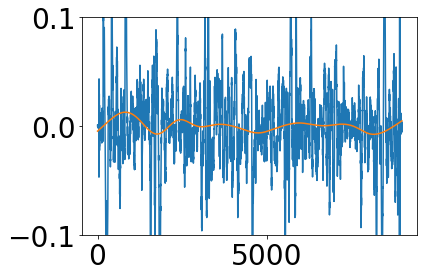

In [58]:
# check sign of IMU heading and angular velocity

imu_ang_vel_z_smooth, _ = pynumdiff.linear_model.savgoldiff(data.imu_ang_vel_z.values, dt, [1, 1000, 1000])

plt.plot(data.imu_ang_vel_z.values)
plt.plot(imu_ang_vel_z_smooth)
plt.ylim(-0.1, 0.1)

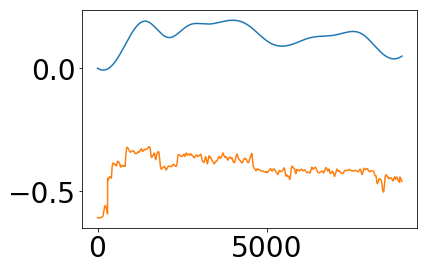

In [59]:
plt.plot(np.cumsum(imu_ang_vel_z_smooth)*dt)
plt.plot(-data.imu_ang_z.values) # << note minus sign!

In [60]:
phi = (-data.imu_ang_z - 13*np.pi/180. )#+ np.pi/2.) 

# Optic flow

### Magnitude

(0, 5)

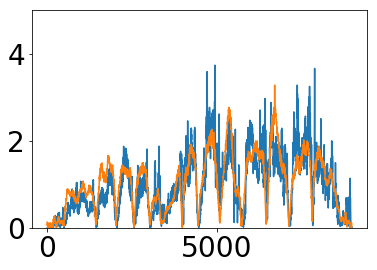

In [61]:
plt.plot(data.opflow_mag.values*zpos*0.07) # velocity = optic_flow * distance * scalefactor
plt.plot(speed_xy)

plt.ylim(0, 5)

### Direction of optic flow compared to x, y motion

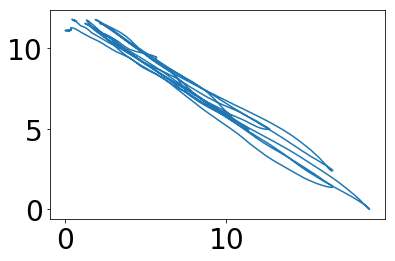

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(xpos, ypos)
ax.set_aspect('equal')

In [63]:
psi_global = np.arctan2(yvel, xvel)

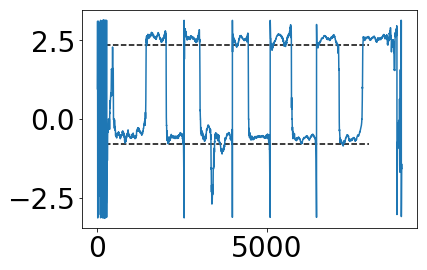

In [64]:
plt.plot(psi_global)

# plot -45, and +135 deg lines for sanity checkt
plt.hlines([-45*np.pi/180., 135*np.pi/180.], 0, 8000, linestyles='--') 

In [65]:
psi = wrap_angle(psi_global - phi)
psi_measurement = wrap_angle(data.opflow_ang - np.pi/2.)

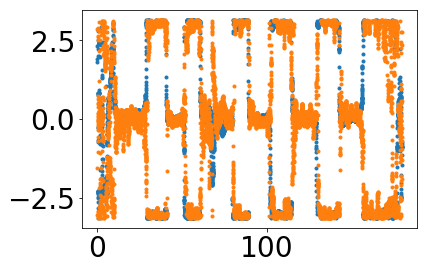

In [66]:
plt.plot(data.master_time, psi, '.')
plt.plot(data.master_time, psi_measurement, '.')

In [67]:
v_para = speed_xy*np.cos(psi)
v_perp = speed_xy*np.sin(psi)

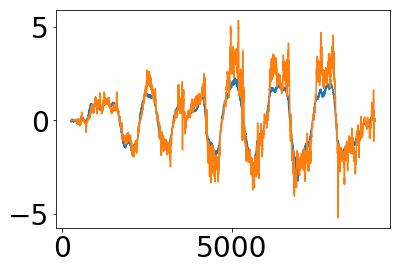

In [68]:
sensor_of_para = data.opflow_mag*np.cos(psi_measurement)

plt.plot(v_para)
plt.plot(sensor_of_para*zpos*0.1)

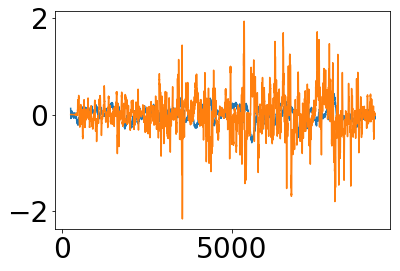

In [69]:
sensor_of_perp = data.opflow_mag*np.sin(psi_measurement)

plt.plot(v_perp)
plt.plot(sensor_of_perp*zpos*0.1)

# Now check / fix wind sensors

In [70]:
df = pandas.DataFrame({'psi': psi,
                       'sensor_psi': psi_measurement,
                       'phi': phi,
                       'sensor_phi': phi,
                       'xpos': xpos,
                       'ypos': ypos,
                       'v_para': v_para,
                       'v_perp': v_perp,
                       'sensor_of_para': sensor_of_para,
                       'sensor_of_perp': sensor_of_perp,
                       'zeta': correct_wind_direction_for_trisonica(data.D.values),
                       'w': data.S,
                       't': data.master_time})

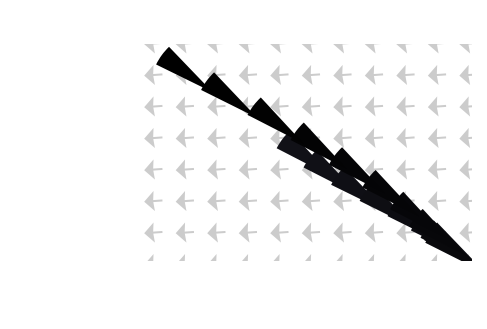

In [71]:
plot_trajec(df.iloc[6250:6750], size_radius=2, nskip = 30, 
            wind_quiver_res=10, wind_quiver_headwidth=10, wind_quiver_alpha=0.2)

In [72]:
df['air_para'] = df.v_para - df.w*np.cos(df.phi - df.zeta)
df['air_perp'] = df.v_perp + df.w*np.sin(df.phi - df.zeta)
df['gamma'] = np.arctan2(df.air_perp, df.air_para)

df['sensor_gamma'] = -correct_wind_direction_for_trisonica(data.drone_wind_ang) # flip from wind direction to airspeed direction
df['sensor_wind_mag'] = data.drone_wind_mag
df['sensor_air_para'] = df.sensor_wind_mag*np.cos(df.sensor_gamma)
df['sensor_air_perp'] = df.sensor_wind_mag*np.sin(df.sensor_gamma)

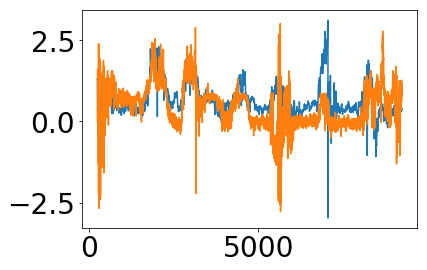

In [73]:
plt.plot(df.gamma)
plt.plot(df.sensor_gamma)

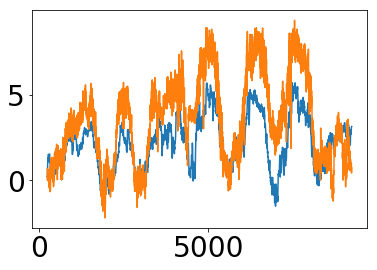

In [74]:
plt.plot(df.air_para)
plt.plot(df.sensor_air_para)

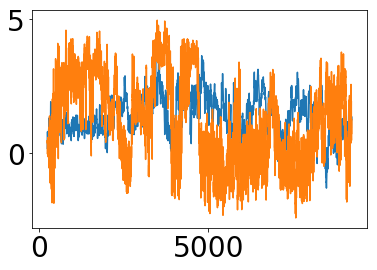

In [75]:
plt.plot(df.air_perp)
plt.plot(df.sensor_air_perp)

# Save dataframe

In [ ]:
df.to_hdf(os.path.join(home_folder_name, 'botfly_trajectory.hdf'), 'botfly')